In [27]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
with open('beverage_dispenser.json') as file:
    data = json.loads(file.read())

data = data['content']

# Data exploration

In [4]:
df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11042 entries, 0 to 11041
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype              
---  ------   --------------  -----              
 0   date     11042 non-null  datetime64[ns, UTC]
 1   product  11042 non-null  object             
 2   machine  11042 non-null  object             
dtypes: datetime64[ns, UTC](1), object(2)
memory usage: 258.9+ KB


In [158]:
date_deb = df.iloc[0]['date']
date_fin = df.iloc[-1]['date']

duration = (date_fin - date_deb).days
print(f"Logs duration: {duration} days")

Logs duration: 41 days


## Products sales

In [5]:
df.pivot_table(
    index='machine',
    columns='product',
    aggfunc='size',
    fill_value=0
)

product,coffee,nrj,refill,soda
machine,,,,
A,1680,346,6,720
B,1680,353,6,720
C,1680,360,6,720
D,1680,359,6,720


## Profits

In [175]:
print(f"Duration of logs: {duration} days\n")

# Profits of product sales

quantity = dict(df.value_counts('product'))
quantity.pop('refill')

margin = {'coffee' : 1-0.3, 'soda': 1.6-0.6, 'nrj': 1.8-0.8}

profits = {k : v1*v2 for k, v1, v2 in zip(
    list(quantity.keys()),
    list(quantity.values()),
    list(margin.values())
)}

product_profits = sum(list(profits.values()))
print(f"Products sales profits: {product_profits}€")


# Cost of refill

refill = df['product'] == 'refill'
nb_refill = len(df[refill]['date'].dt.strftime('%m/%d/%Y').unique())
cost_refill = nb_refill * 50 + nb_refill*4*20

print(f"Cost of refill: {cost_refill}€")


# Location and maintenance costs
daily_maintenance_cost = round(1200 / 365, 2)
daily_location_cost = round(150 * 12 / 365, 2)

maintenance_cost = round(daily_maintenance_cost * duration, 2)
location_cost = round(daily_location_cost * duration, 2)

fixed_costs = maintenance_cost + location_cost
print(f"Fixed costs: {fixed_costs}€")

# Total profits

total_profits = product_profits - fixed_costs - cost_refill
print(f"Total profits: {total_profits}€ ")

Duration of logs: 41 days

Products sales profits: 9002.0€
Cost of refill: 780€
Fixed costs: 337.02€
Total profits: 7884.98€ 


# Breakdown of sales over the week

In [176]:
df['day'] = df['date'].dt.day_name()
df['time_slot'] = (df['date'].dt.floor('1H')).dt.hour

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['day'] = pd.Categorical(df['day'], categories=day_order, ordered=True)

display(df)

,date,product,machine,day,time_slot,count,stock_coffee,stock_soda,stock_nrj
0,2019-11-14 11:53:35+00:00,refill,A,Thursday,11,0,280,120,60
1,2019-11-14 12:06:35+00:00,coffee,A,Thursday,12,0,279,120,60
2,2019-11-14 12:07:59+00:00,soda,A,Thursday,12,0,279,119,60
3,2019-11-14 12:13:45+00:00,soda,A,Thursday,12,1,279,118,60
4,2019-11-14 12:22:35+00:00,coffee,A,Thursday,12,1,278,118,60
...,...,...,...,...,...,...,...,...,...
11037,2019-12-25 20:10:53+00:00,nrj,A,Wednesday,20,1413,0,0,3
11038,2019-12-25 20:16:30+00:00,nrj,B,Wednesday,20,1414,270,119,49
11039,2019-12-25 20:26:35+00:00,nrj,B,Wednesday,20,1415,270,119,48
11040,2019-12-25 21:11:55+00:00,nrj,B,Wednesday,21,1416,270,119,47


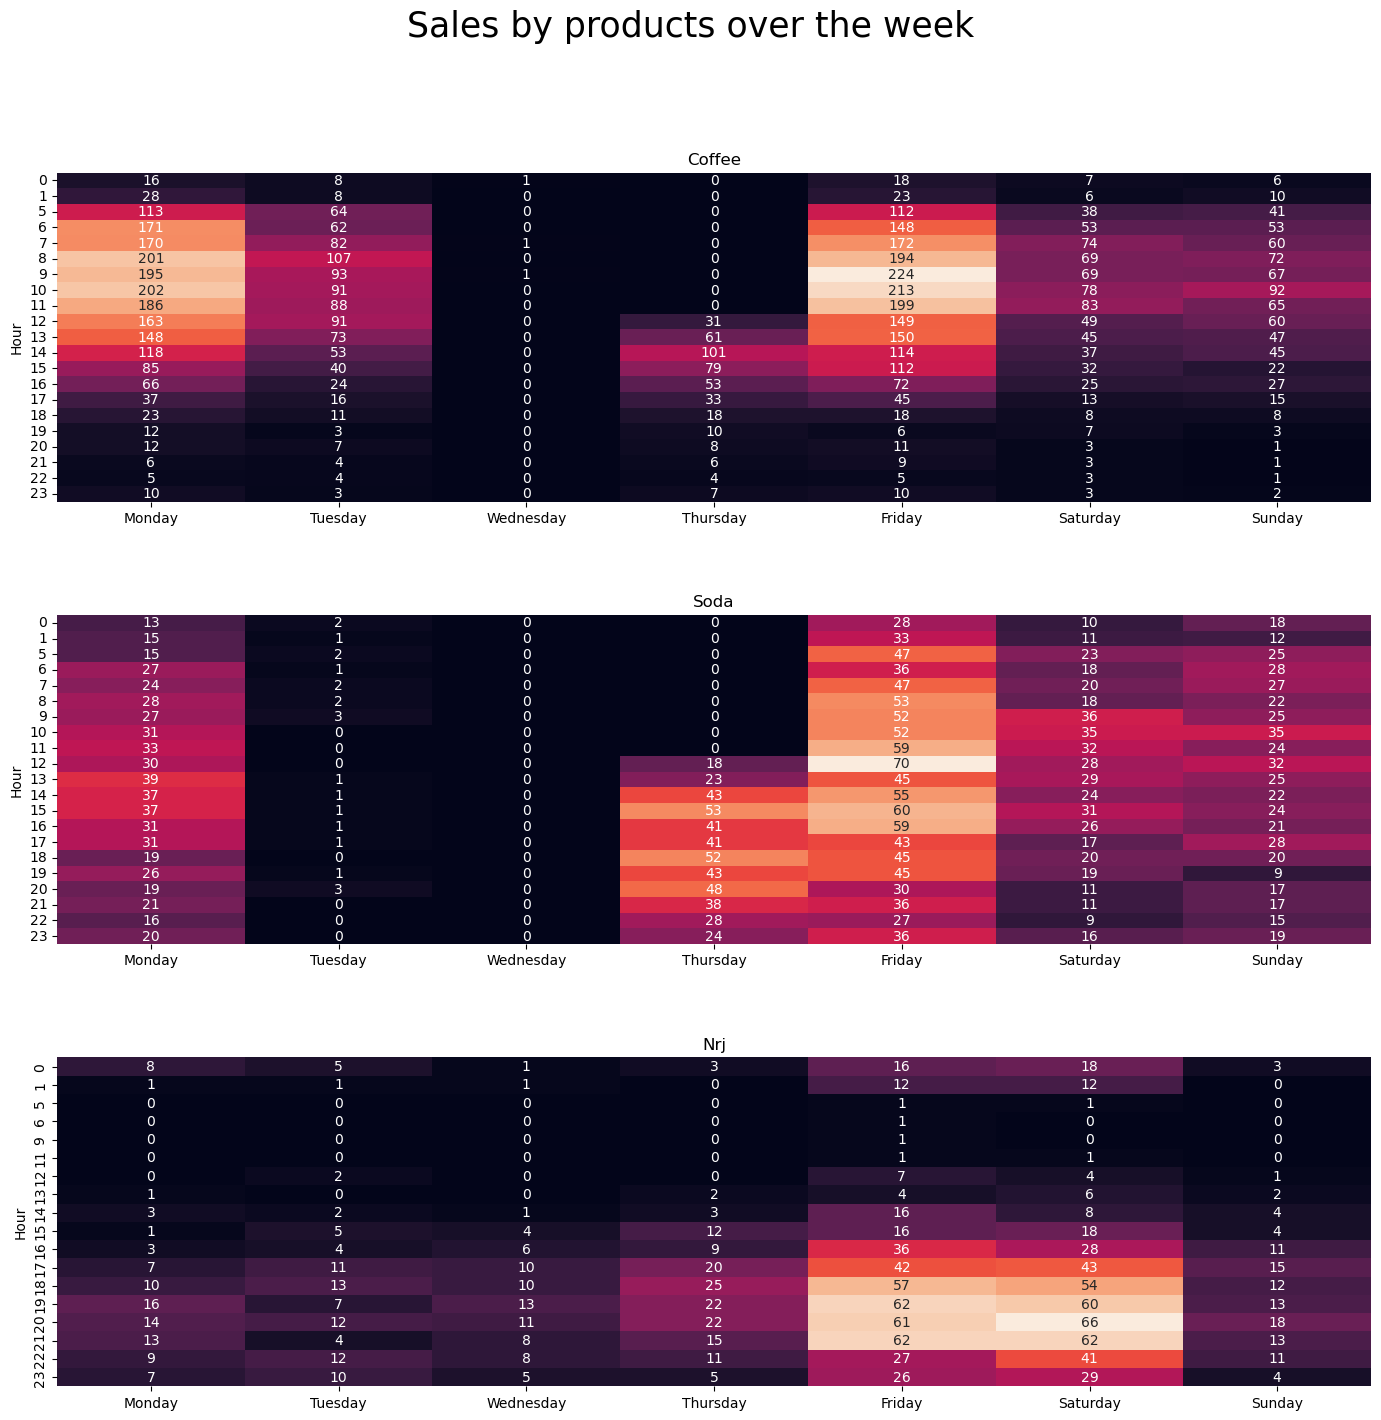

In [188]:
list_product = list(df['product'].unique())[1:]

fig, axes = plt.subplots(nrows=len(list_product), ncols=1, figsize=(15,15))

axes = axes.flatten()

for i, product in enumerate(list_product):
    product_filter = df['product'] == product
    table = df[product_filter].pivot_table(
        'product',
        'time_slot',
        'day',
        aggfunc='count',
    )
    table = table[day_order]

    sns.heatmap(table, cmap='rocket', annot=True, fmt='.0f', ax=axes[i], cbar=False)
    axes[i].set_title(f"{product.capitalize()}")
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Hour')

fig.suptitle('Sales by products over the week', fontsize=25)
fig.tight_layout(pad=5.0)

plt.show()

**Coffee**\
Most of sales are on Monday and Friday mornings

**Soda**\
Most of sales are from Thursday afternoon to Friday night

**Energy drink**\
Most of sales are on Friday and Saturday evening

**Globals**\
Almost no sales on Wednesdays.\
Either there's a real change in traffic on that day, or <u>there's a stock problem.<u>

# Stock monitoring

In [42]:
df[['stock_coffee', 'stock_soda', 'stock_nrj']] = "", "", ""

In [189]:
def update_stock(product, stock):
    max_stock = np.array([280, 120, 60])
    if product == 'refill':
        stock = max_stock

    elif product == 'coffee':
        stock = stock - np.array([1, 0, 0])

    elif product == 'soda':
        stock = stock - np.array([0, 1, 0])

    elif product == 'nrj':
        stock = stock - np.array([0, 0, 1])

    return stock


max_stock = np.array([280, 120, 60])
stock_A = stock_B = stock_C = stock_D = max_stock

for i, row in df.sort_values('date').iterrows():
    if row['machine'] == 'A':
        stock = update_stock(row['product'], stock_A)
        stock_A = stock

    elif row['machine'] == 'B':  
        stock = update_stock(row['product'], stock_B)
        stock_B = stock

    elif row['machine'] == 'C':  
        stock = update_stock(row['product'], stock_C)
        stock_B = stock
        
    else:
        stock = update_stock(row['product'], stock_D)
        stock_D = stock
    
    df.at[i,'stock_coffee'] = stock[0]
    df.at[i,'stock_soda'] = stock[1]
    df.at[i,'stock_nrj'] = stock[2]

display(df.head())

,date,product,machine,day,time_slot,count,stock_coffee,stock_soda,stock_nrj
0,2019-11-14 11:53:35+00:00,refill,A,Thursday,11,0,280,120,60
1,2019-11-14 12:06:35+00:00,coffee,A,Thursday,12,0,279,120,60
2,2019-11-14 12:07:59+00:00,soda,A,Thursday,12,0,279,119,60
3,2019-11-14 12:13:45+00:00,soda,A,Thursday,12,1,279,118,60
4,2019-11-14 12:22:35+00:00,coffee,A,Thursday,12,1,278,118,60


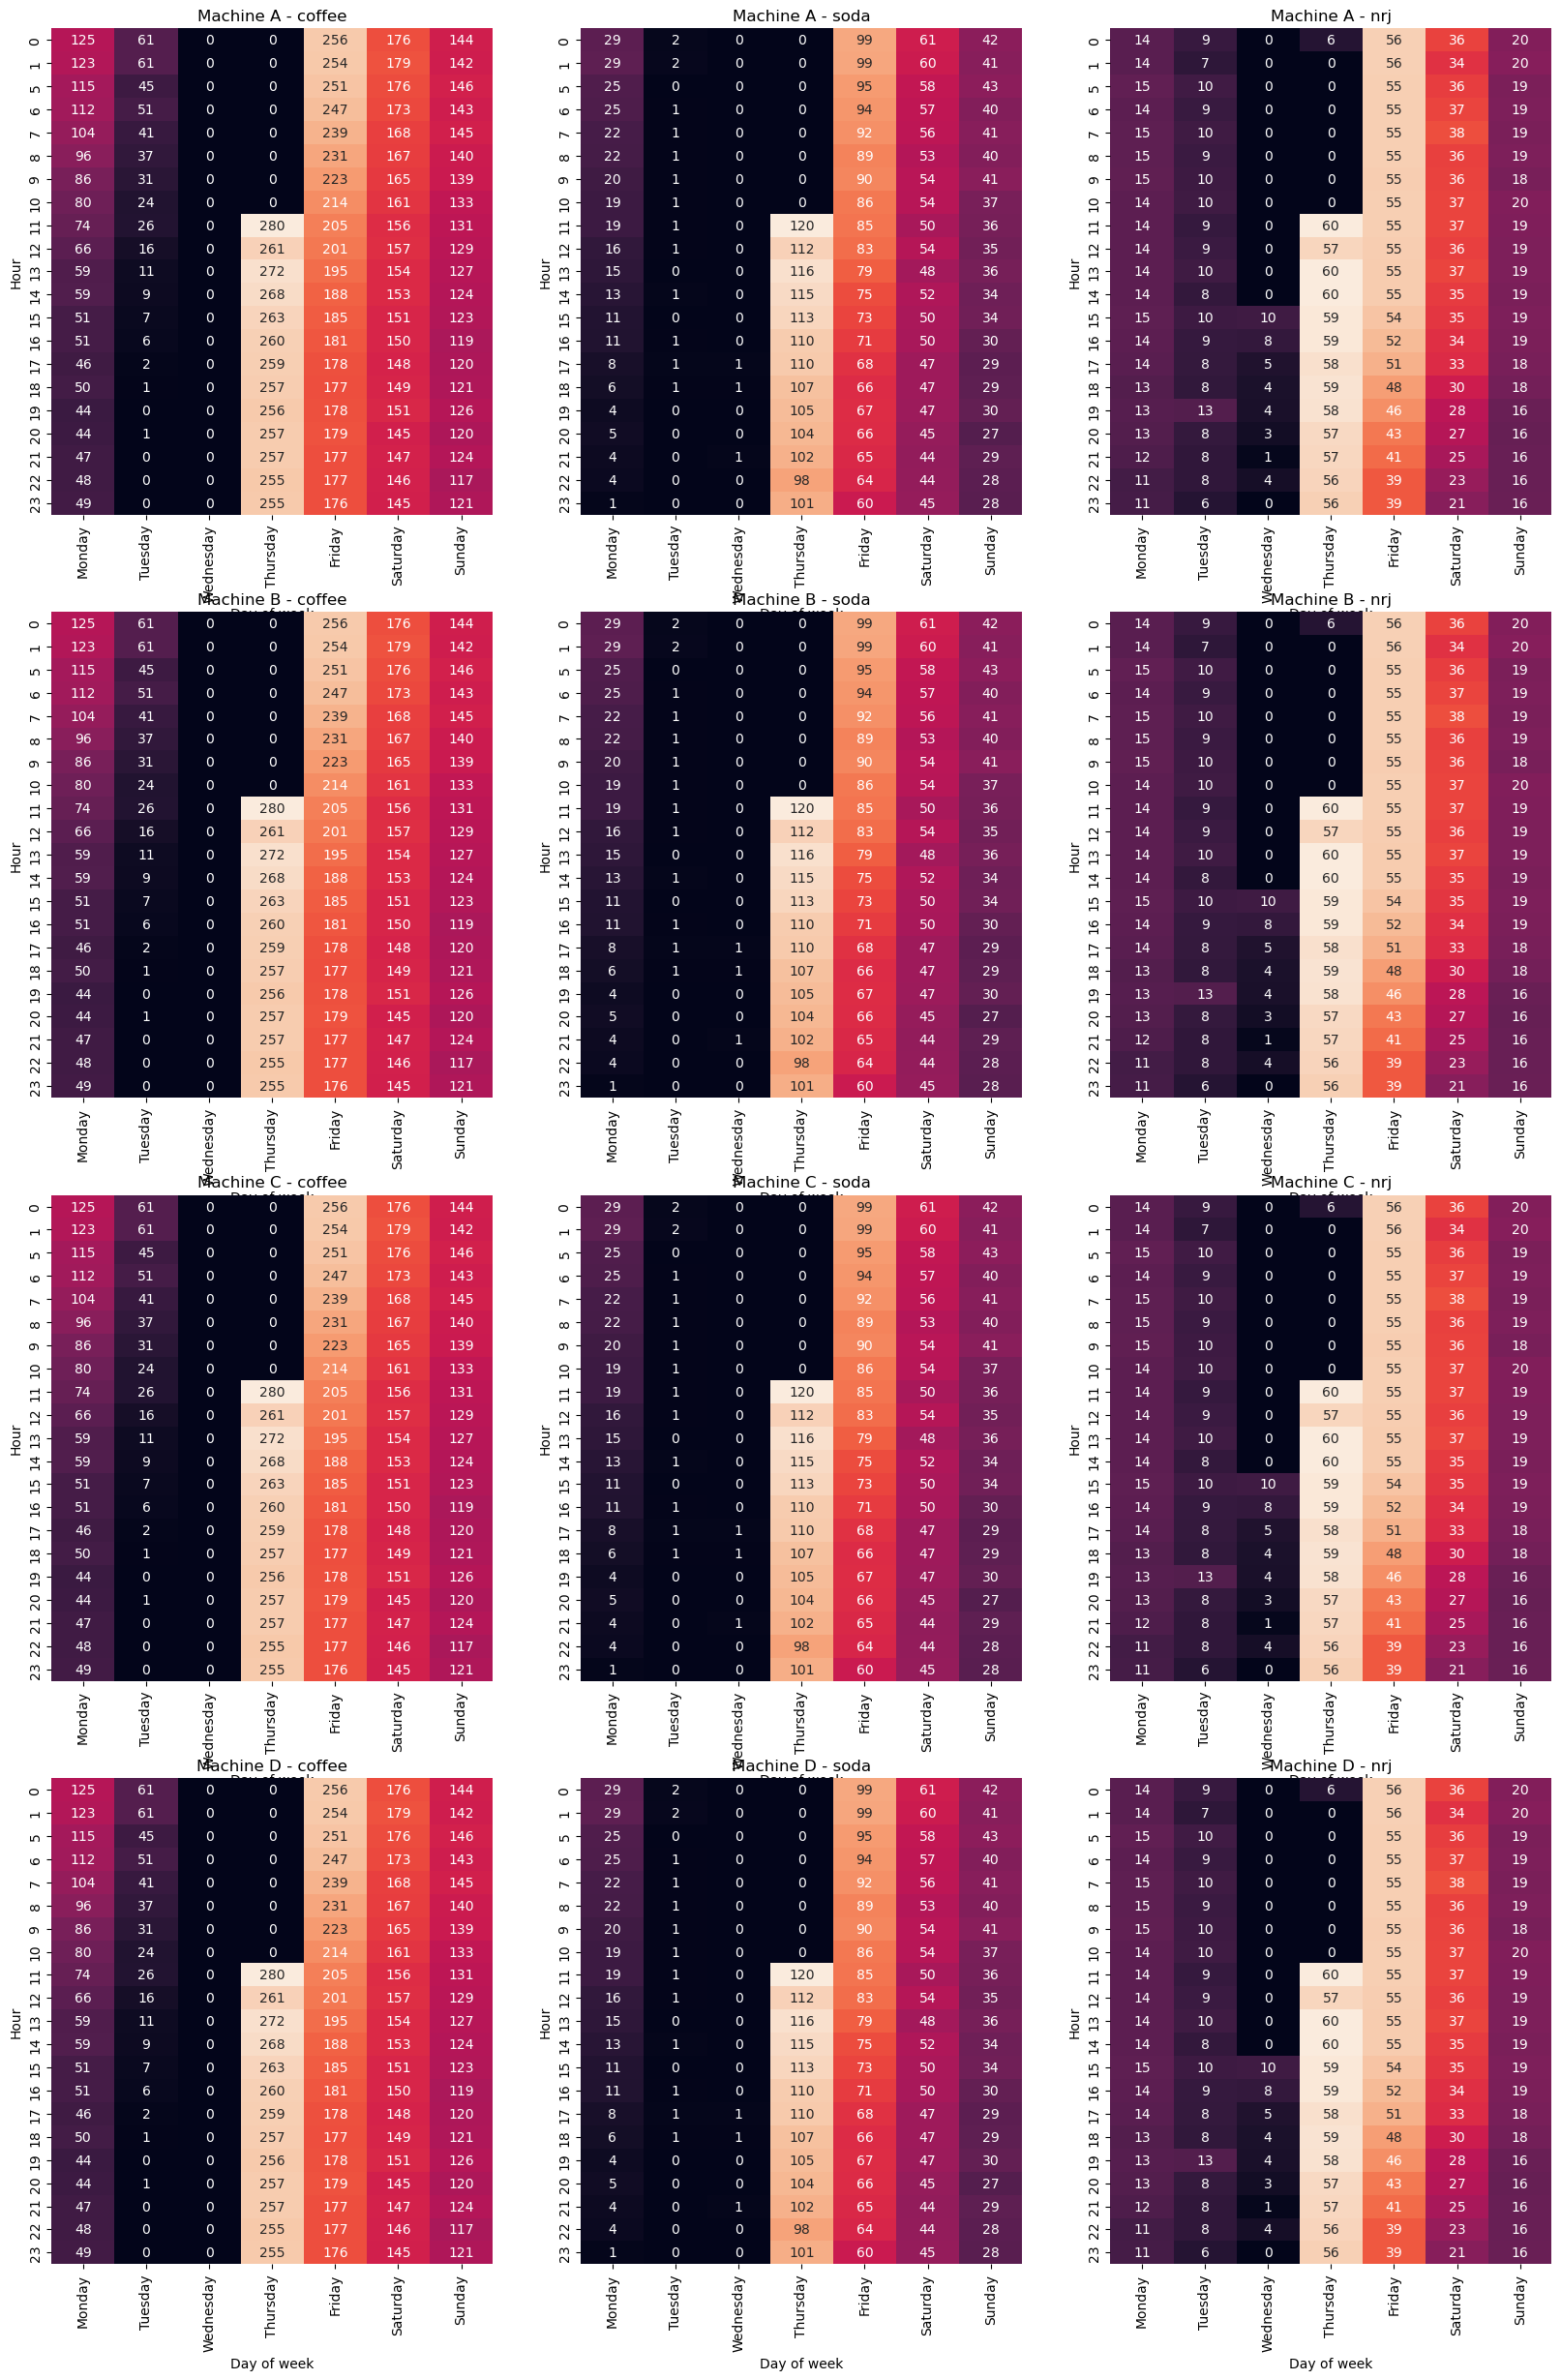

In [76]:
machines = list(df['machine'].unique())
products = list(df['product'].unique())[1:]

fig, axes = plt.subplots(
    nrows=len(machines),
    ncols=len(products),
    figsize=(20,30)
)

axes = axes.flatten()

for i, machine in enumerate(machines):
    for j, product in enumerate(products):
        table = df[df['machine'] == 'A'].pivot_table(
                f'stock_{product}',
                'time_slot',
                'day',
                aggfunc='mean',
                fill_value=0
            )
        sns.heatmap(
            table,
            cmap='rocket',
            annot=True,
            fmt='.0f',
            ax=axes[3*i+j],
            cbar=False
        )
        axes[3*i+j].set_title(f"Machine {machine} - {product}")
        axes[3*i+j].set_xlabel('Day of week')
        axes[3*i+j].set_ylabel('Hour')

plt.show()

## Mean time the dispenser is empty

In [211]:
empty_time = {'coffee': 0, 'soda': 0, 'nrj': 0}

for machine in machines:
    for product in products:
        filter_refill = df['product'] == 'refill'
        filter_product = df['product'] == product
        filter_machine = df['machine'] == machine
        filter_stock = df[f'stock_{product}'] <= 0
        
        df_temp = df[filter_machine & ((filter_stock & filter_product) | filter_refill)]
        df_temp = df_temp.iloc[1:].reset_index() #Take out first refill

        if product in list(df_temp['product']):
            for i, row in df_temp.sort_index().iterrows():
                if row['product'] == 'refill':
                    if df_temp.iloc[i-1]['product'] != 'refill':
                        date_refill = row['date']
                        date_out_of_stock = df_temp.iloc[i-1]['date']
                        delta = date_refill - date_out_of_stock 
                        delta = delta.days*24 + delta.seconds//3600
                        empty_time[product] += (delta)
                

print(f"Total time when at least 1 product is missing: {sum(list(empty_time.values()))} hours\n\nDetail\n")
for key, value in empty_time.items():
    print(f"{key.capitalize()}: {value}h")

Total time when at least 1 product is missing: 1021 hours

Detail

Coffee: 412h
Soda: 441h
Nrj: 168h


## Average weekday sales per hour per product

In [219]:
filter_days = df['day'].isin(['Wednesday', 'Saturday', 'Sunday']) #Remove Wednesday so as not to reduce the average sales
filter_refill = df['product'] != 'refill'
df_temp = df[~filter_days & filter_refill]

df_temp

,date,product,machine,day,time_slot,count,stock_coffee,stock_soda,stock_nrj
1,2019-11-14 12:06:35+00:00,coffee,A,Thursday,12,0,279,120,60
2,2019-11-14 12:07:59+00:00,soda,A,Thursday,12,0,279,119,60
3,2019-11-14 12:13:45+00:00,soda,A,Thursday,12,1,279,118,60
4,2019-11-14 12:22:35+00:00,coffee,A,Thursday,12,1,278,118,60
5,2019-11-14 12:37:44+00:00,soda,A,Thursday,12,2,278,117,60
...,...,...,...,...,...,...,...,...,...
11028,2019-12-24 22:39:42+00:00,nrj,B,Tuesday,22,1405,270,119,55
11029,2019-12-24 22:56:02+00:00,nrj,B,Tuesday,22,1406,270,119,54
11030,2019-12-24 23:27:52+00:00,nrj,B,Tuesday,23,1407,270,119,53
11031,2019-12-24 23:31:28+00:00,coffee,D,Tuesday,23,6719,0,0,0
